# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [141]:
import xarray as xr
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [166]:
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.api import VAR

from xgboost import XGBRegressor


# Loading the Data

In [8]:
# Load the netCDF file for Mean Temperature
d1 = xr.open_dataset('Worst_senario rcp8.5/dataset-sis-biodiversity/BIO01_ipsl-cm5a-lr_rcp85_r1i1p1_1950-2100_v1.0.nc')

# Extract the annual mean temperature data
annual_mean_temp = d1['BIO01'].mean(dim=['latitude', 'longitude'])

# Convert the data to a pandas DataFrame
temp = annual_mean_temp.to_dataframe(name='temperature')

# Reset the index to make 'time' a column
temp = temp.reset_index()

# Convert the 'time' column to a pandas datetime object
temp['time'] = pd.to_datetime(temp['time'])

# Set the 'time' column as the index
temp = temp.set_index('time')

# Split the data into training and test sets
temp_train = temp.loc['1950-01-01':'2000-01-01', 'temperature']
temp_test = temp.loc['2001-01-01':'2018-01-01', 'temperature']

In [13]:
# Load the netCDF file for Mean PRECIPITATION
d2 = xr.open_dataset('Worst_senario rcp8.5/dataset-sis-biodiversity/BIO12_ipsl-cm5a-lr_rcp85_r1i1p1_1950-2100_v1.0.nc')

# Extract the annual mean temperature data
annual_mean_prec = d2['BIO12'].mean(dim=['latitude', 'longitude'])

# Convert the data to a pandas DataFrame
prec = annual_mean_prec.to_dataframe(name='precipitation')

# Reset the index to make 'time' a column
prec = prec.reset_index()

# Convert the 'time' column to a pandas datetime object
prec['time'] = pd.to_datetime(prec['time'])

# Set the 'time' column as the index
prec = prec.set_index('time')

# Split the data into training and test sets
prec_train = prec.loc['1950-01-01':'2000-01-01', 'precipitation']
prec_test = prec.loc['2001-01-01':'2018-01-01', 'precipitation']

In [17]:
# Load the netCDF files for the scenario RCP4.5 (only for plotting)

d3 = xr.open_dataset('Worst_senario rcp8.5/Senario_rcp4.5/BIO01_ipsl-cm5a-lr_rcp45_r1i1p1_1950-2100_v1.0.nc')
annual_mean_tempx = d3['BIO01'].mean(dim=['latitude', 'longitude'])
tempx = annual_mean_tempx.to_dataframe(name='temperature')
tempx = tempx.reset_index()
tempx['time'] = pd.to_datetime(tempx['time'])
tempx = tempx.set_index('time')

d4 = xr.open_dataset('Worst_senario rcp8.5/Senario_rcp4.5/BIO12_ipsl-cm5a-lr_rcp45_r1i1p1_1950-2100_v1.0.nc')
annual_mean_precx = d4['BIO12'].mean(dim=['latitude', 'longitude'])
precx = annual_mean_precx.to_dataframe(name='precipitation')
precx = precx.reset_index()
precx['time'] = pd.to_datetime(precx['time'])
precx = precx.set_index('time')


In [19]:
#For prediction to 2035 with the best models

temp_demo_train = temp.loc['1950-01-01':'2018-01-01', 'temperature']
temp_demo_test = temp.loc['2019-01-01':'2035-01-01', 'temperature']


prec_demo_train = prec.loc['1950-01-01':'2018-01-01', 'precipitation']
prec_demo_test = prec.loc['2019-01-01':'2035-01-01', 'precipitation']


# To plot against the data with the scenario rcp4.5
temp_forecast4_5 = tempx.loc['2019-01-01':'2035-01-01', 'temperature']
prec_forecast4_5 = precx.loc['2019-01-01':'2035-01-01', 'precipitation']


# 0. MA Model

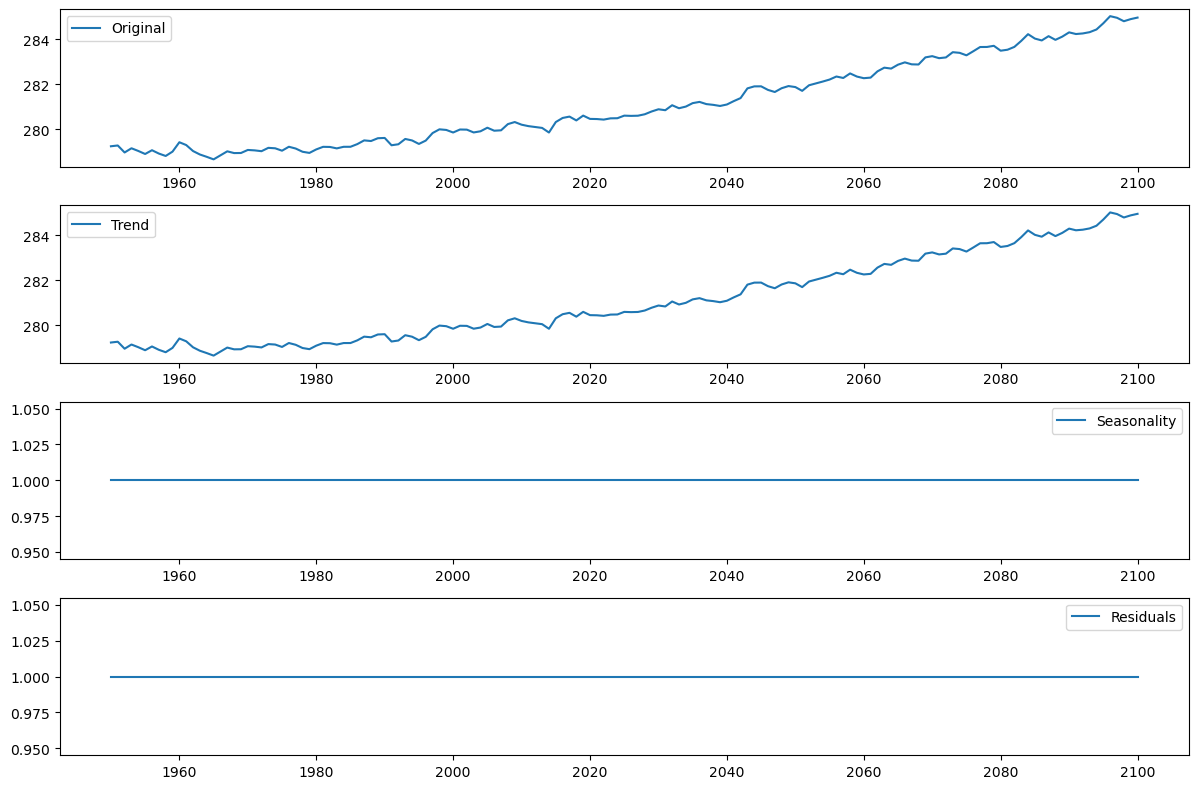

In [214]:
def plot_decomposition(df,model):
    # Perform time series decomposition using additive model
    decomposition = sm.tsa.seasonal_decompose(df, model=model)

    # Plot the original time series, trend, seasonal, and residual components
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

plot_decomposition(temp,model='multiplicative')

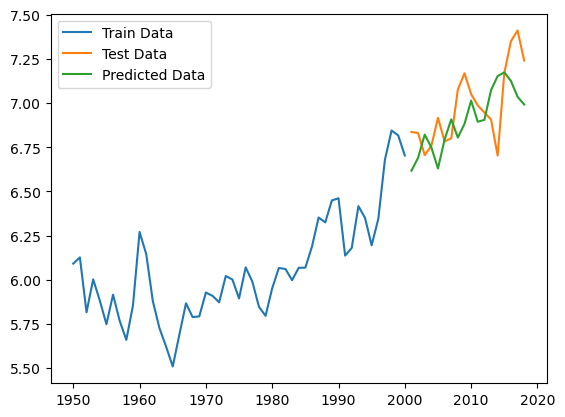

RMSE: 0.21
R2: 0.2125301393967768
MAPE:  0.06119753997963181
AIC:  -39.462795045500144


In [275]:

#if 1st has value and others 0 ==> auto regression
#if 2nd value means (detrending) ARIMA
#if third number has value and others 0, moving average model
modeltest = ARIMA(temp_train, order=(24,0,0)).fit()

# Predict the next 12 months of passenger traffic using the fitted model
pred = modeltest.predict(start=len(temp_train), end=len(temp_train)+17)

# Plot the actual and predicted passenger traffic for the test data
plt.plot(temp_train.index, temp_train-273.15, label='Train Data')
plt.plot(temp_test.index, temp_test-273.15, label='Test Data')
plt.plot(pred.index, pred.values-273.15, label='Predicted Data')
plt.legend()
plt.show()


# Evaluate model performance

r2 = np.square(np.corrcoef(pred, temp_test)[0, 1])
rmse = mean_squared_error(temp_test-273.15, pred-273.15, squared=False)
mape = np.mean(np.abs((temp_test - pred) / temp_test)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2}')
print("MAPE: ", mape)
print("AIC: ", modeltest.aic)




# 1. ARIMA Model

First try with auto_arima to get optimal parameters

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-41.673, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.763, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.870, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38.370, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.457, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-45.650, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45.616, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-43.786, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-46.049, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-48.003, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-49.610, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-48.055, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-42.403, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-49.736, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-40.1

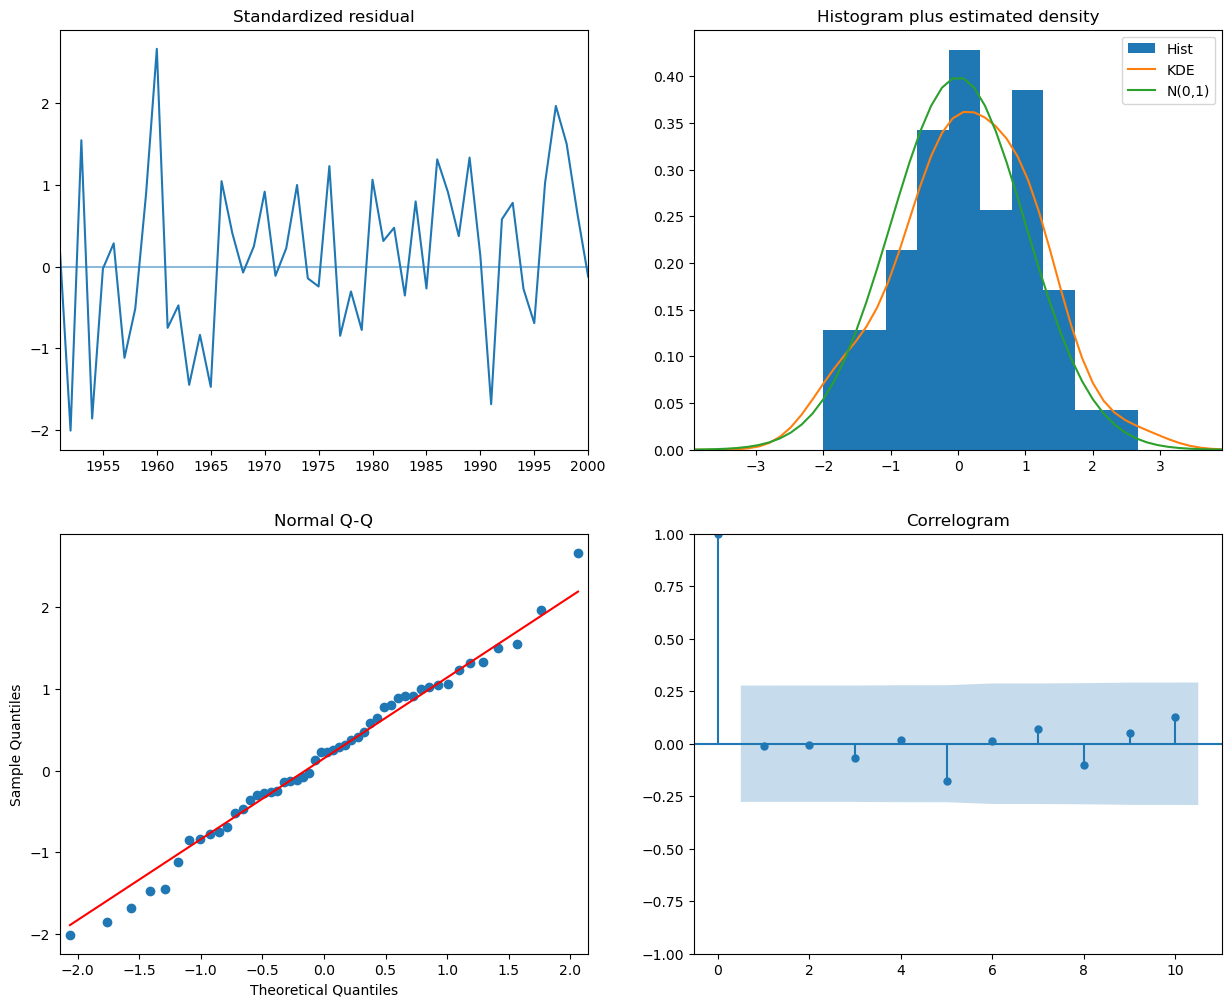

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  27.868
Date:                Thu, 16 Mar 2023   AIC                            -49.736
Time:                        14:50:21   BIC                            -44.000
Sample:                    01-01-1950   HQIC                           -47.552
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1145      0.139      0.823      0.410      -0.158       0.387
ma.L2         -0.5180      0.162     -3.204      0.001      -0.835      -0.201
sigma2         0.0189      0.004      4.567      0.000       0.011       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.95   Prob(JB):                         0.96
Heteroskedasticity (H):               0.65   Skew:                            -0.07
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
#Standard ARIMA Model
ARIMA_model1t = pm.auto_arima(temp_train, 
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=15, max_q=15,
                      m=1,             
                      d=None,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

ARIMA_model1t.plot_diagnostics(figsize=(15,12))
plt.show()

ARIMA_model1t.summary()

Since it didn't give good predictions, I have played with the parameters myselft

## 1.1.1 ARIMA Model on Temperature 

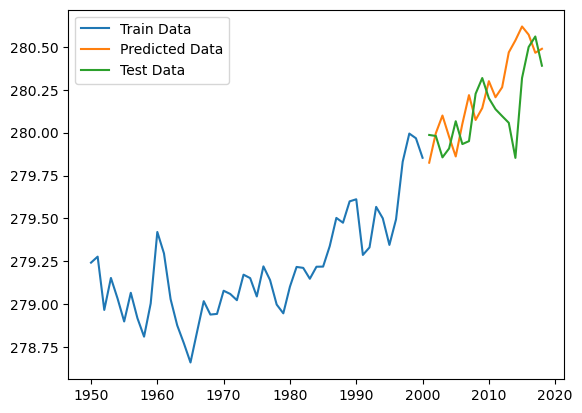

RMSE: 0.24
R2: 0.27838662357788524
MAPE:  0.06765037948694948
AIC:  -14.437169061499986


In [352]:
modeltest = ARIMA(temp_train, order=(24,1,12)).fit()

# Predict the next 12 months of passenger traffic using the fitted model
pred = modeltest.predict(start=len(temp_train), end=len(temp_train)+17)

# Plot the actual and predicted passenger traffic for the test data
plt.plot(temp_train.index, temp_train, label='Train Data')
plt.plot(pred.index, pred.values, label='Predicted Data')
plt.plot(temp_test.index, temp_test, label='Test Data')
plt.legend()
plt.show()

r2 = np.square(np.corrcoef(pred, temp_test)[0, 1])
rmse = mean_squared_error(temp_test-273.15, pred-273.15, squared=False)
mape = np.mean(np.abs((temp_test - pred) / temp_test)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2}')
print("MAPE: ", mape)
print("AIC: ", modeltest.aic)

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                   51
Model:                ARIMA(20, 1, 5)   Log Likelihood                  41.028
Date:                Fri, 17 Mar 2023   AIC                            -30.056
Time:                        23:58:57   BIC                             19.657
Sample:                    01-01-1950   HQIC                           -11.125
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0806      0.640      0.126      0.900      -1.174       1.335
ar.L2         -0.1554      0.505     -0.308      0.758      -1.146       0.835
ar.L3         -0.1680      0.366     -0.460      0.6

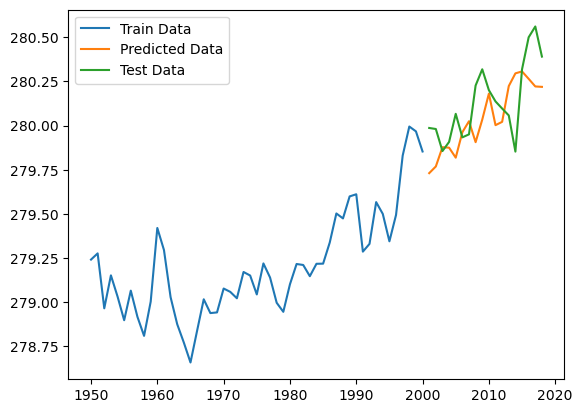

RMSE: 0.21
R2: 0.2806034424422358
MAPE:  0.06097487615343828
AIC:  -30.055956818036222


In [353]:
# Fit an ARIMA model to the train data
#trend, differencition (1 = previous value), mov av=> responsible for random error
model = ARIMA(temp_train, order=(20, 1, 5))
results = model.fit()
# Print a summary of the model fit
print(results.summary())
# Generate forecasts for the test data
forecast = results.forecast(steps=len(temp_test))

# Plot the train, test, and forecasted data

plt.plot(temp_train.index, temp_train, label='Train Data')
plt.plot(forecast.index, forecast.values, label='Predicted Data')
plt.plot(temp_test.index, temp_test, label='Test Data')
plt.legend()
plt.show()

r2 = np.square(np.corrcoef(forecast, temp_test)[0, 1])
rmse = mean_squared_error(temp_test-273.15, forecast-273.15, squared=False)
mape = np.mean(np.abs((temp_test - forecast) / temp_test)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2}')
print("MAPE: ", mape)
print("AIC: ", results.aic)

## 1.1.2 ARIMA Model on Precipitation

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1031.020, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1037.567, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1034.491, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1045.928, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1172.256, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.730 seconds


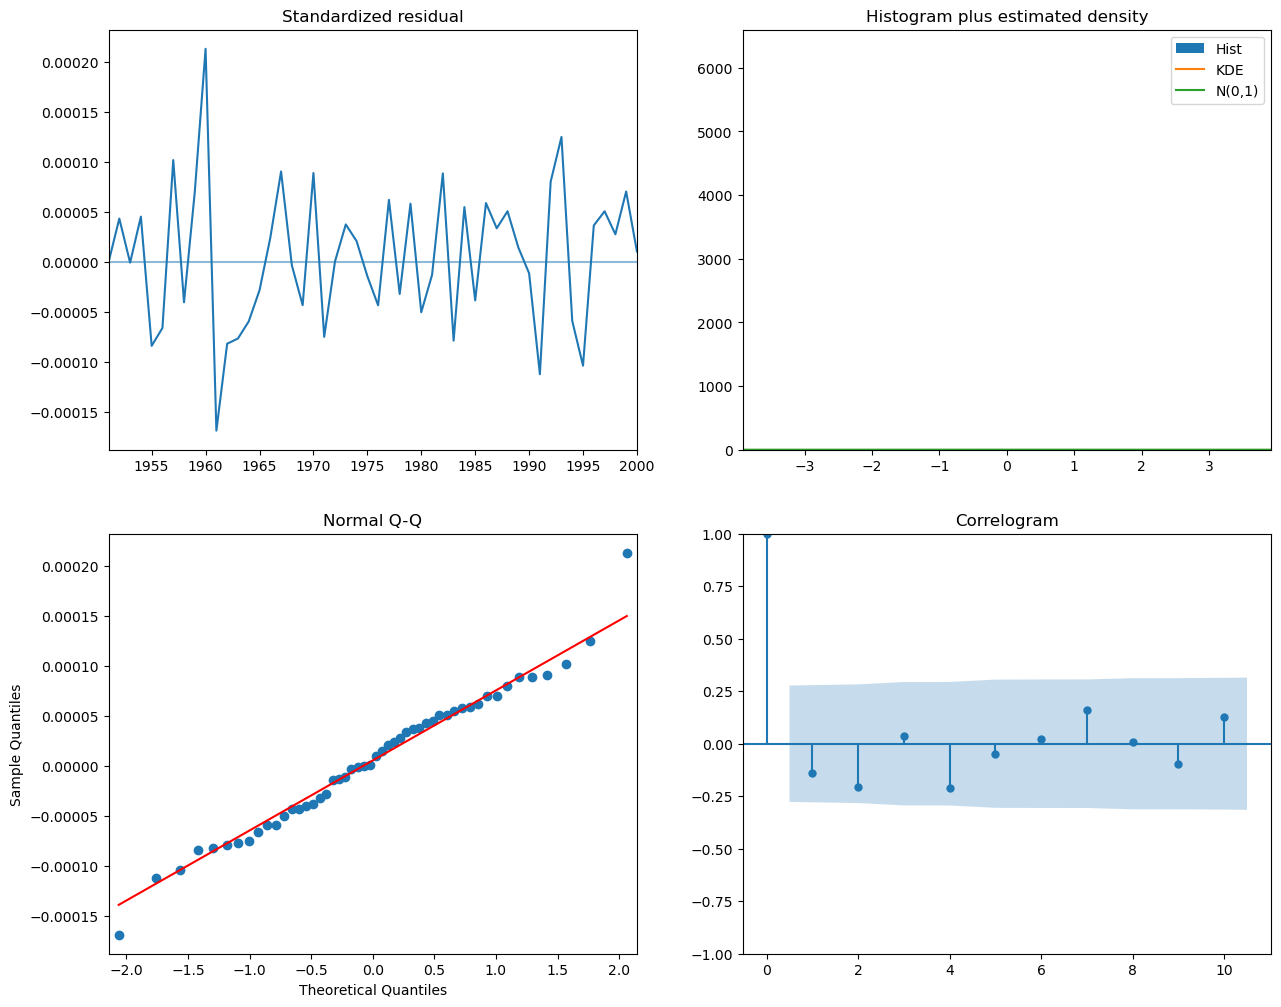

In [94]:
#Standard ARIMA Model


ARIMA_model1p = pm.auto_arima(prec_train, 
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=15, max_q=15,
                      m=1,             
                      d=None,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


ARIMA_model1p.plot_diagnostics(figsize=(15,12))
plt.show()

                               SARIMAX Results                                
Dep. Variable:          precipitation   No. Observations:                   51
Model:                 ARIMA(8, 0, 0)   Log Likelihood                 539.120
Date:                Thu, 16 Mar 2023   AIC                          -1058.239
Time:                        21:50:44   BIC                          -1038.921
Sample:                    01-01-1950   HQIC                         -1050.857
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.839e-08   4.06e-21      7e+12      0.000    2.84e-08    2.84e-08
ar.L1          0.7837   7.78e-20   1.01e+19      0.000       0.784       0.784
ar.L2         -0.1075   7.23e-20  -1.49e+18      0.0

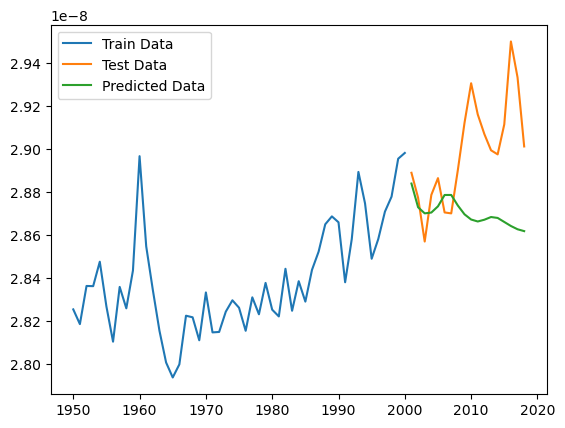

RMSE: 0.00
R2: 0.42159244612224045
MAPE:  1.0961944648030535
AIC:  -1058.2390755730062


In [292]:
# Fit an ARIMA model to the train data
#trend, differencition (1 = previous value), mov av=> responsible for random error
model = ARIMA(prec_train, order=(8, 0, 0))
results = model.fit()
# Print a summary of the model fit
print(results.summary())
# Generate forecasts for the test data
forecast = results.forecast(steps=len(prec_test))

# Plot the train, test, and forecasted data

plt.plot(prec_train.index, prec_train, label='Train Data')
plt.plot(prec_test.index, prec_test, label='Test Data')
plt.plot(forecast.index, forecast.values, label='Predicted Data')
plt.legend()
plt.show()

r2 = np.square(np.corrcoef(forecast, prec_test)[0, 1])
rmse = mean_squared_error(prec_test-273.15, forecast-273.15, squared=False)
mape = np.mean(np.abs((prec_test - forecast) / prec_test)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2}')
print("MAPE: ", mape)
print("AIC: ", results.aic)

# 2. SARIMA Model

## 2.1.1 On Temperature

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=14.786, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-9.267, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=24.136, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-9.313, Time=0.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-10.845, Time=0.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=-9.776, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12] intercept
Total fit time: 4.039 

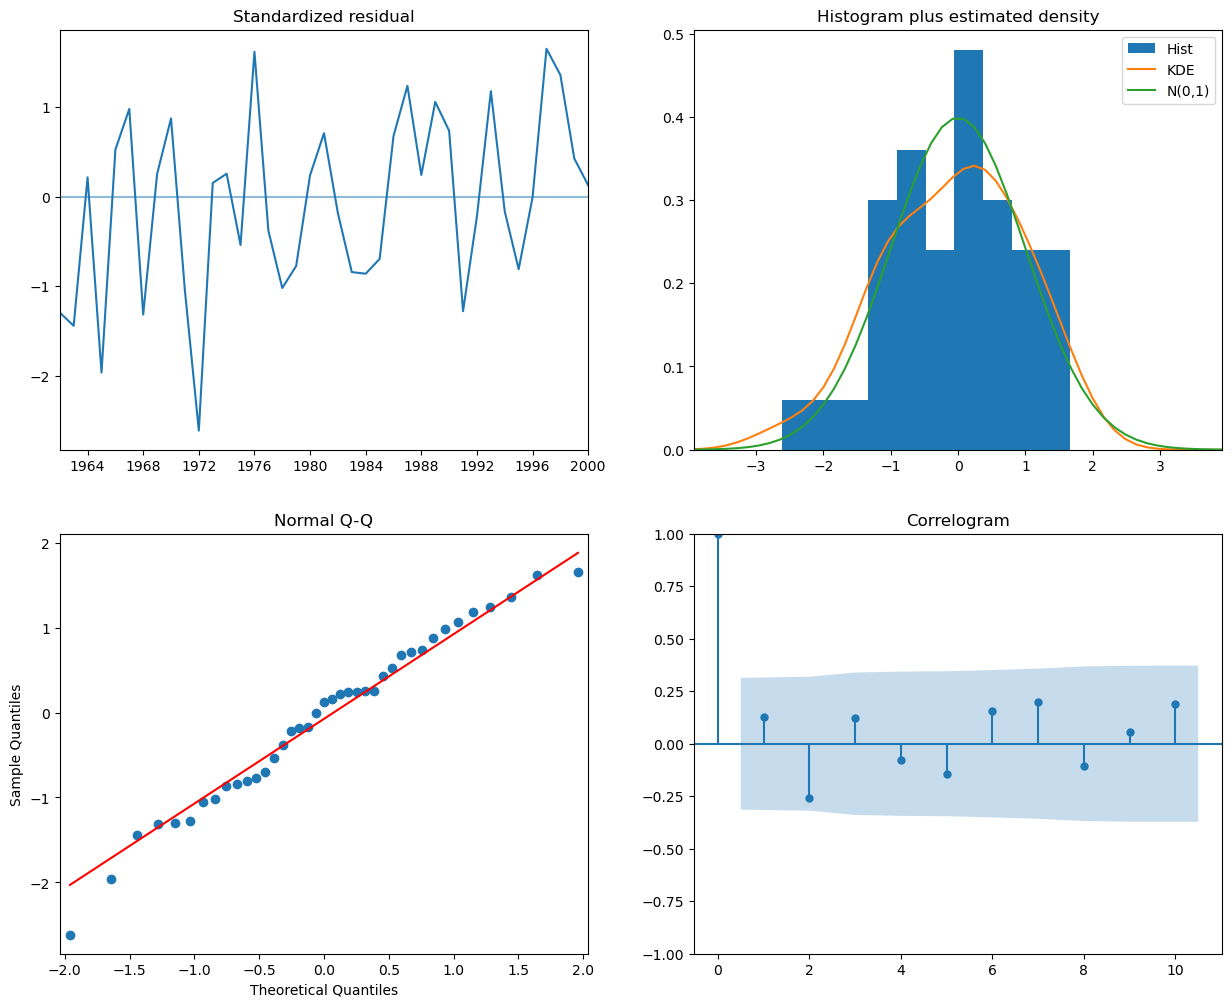

In [137]:
SARIMA_model = pm.auto_arima(temp_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal for SARIMA
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

The best parameters found for SARIMA give bad results, so I have played with the parameters myself

RMSE: 0.63


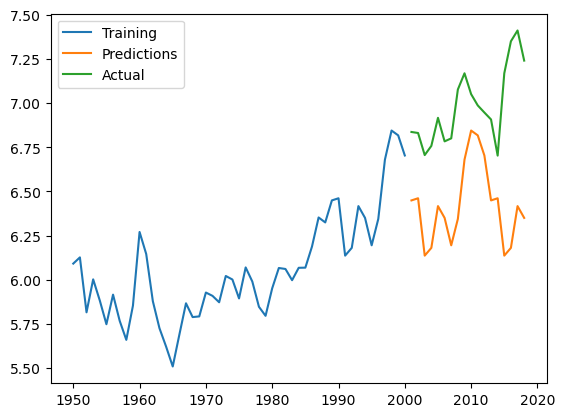

RMSE:  0.6294668739899266
R2:  0.0062999626808603855
MAPE:  0.19955548219409647
AIC:  -50.2901391336272


In [269]:
# Fit SARIMA model
model = SARIMAX(temp_train, order=(24,0,0), seasonal_order=(0,1,1,12))
results = model.fit()

# Make predictions
predictions = results.predict(start=len(temp_train), end=len(temp_train)+17, dynamic=False)

# Evaluate model performance
mse = mean_squared_error(temp_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

# Visualize predictions and actual values
plt.plot(temp_train-273.15, label='Training')
plt.plot(temp_test.index, predictions-273.15, label='Predictions')
plt.plot(temp_test-273.15, label='Actual')
plt.legend()
plt.show()

rmse = mean_squared_error(temp_test, predictions, squared=False)
r2 = np.square(np.corrcoef(predictions, temp_test)[0, 1])
mape = np.mean(np.abs((temp_test - predictions) / temp_test)) * 100

print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)
print("AIC: ", model_fit.aic)

## 2.1.2 On Precipitation

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-810.534, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-784.562, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-813.277, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-804.481, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-793.220, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-815.095, Time=0.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-813.095, Time=0.10 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-634.955, Time=0.52 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-813.043, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-812.534, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-714.914, Time=0.20 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=-778.562, Time=0.54 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=-791.220, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 2.690 seconds


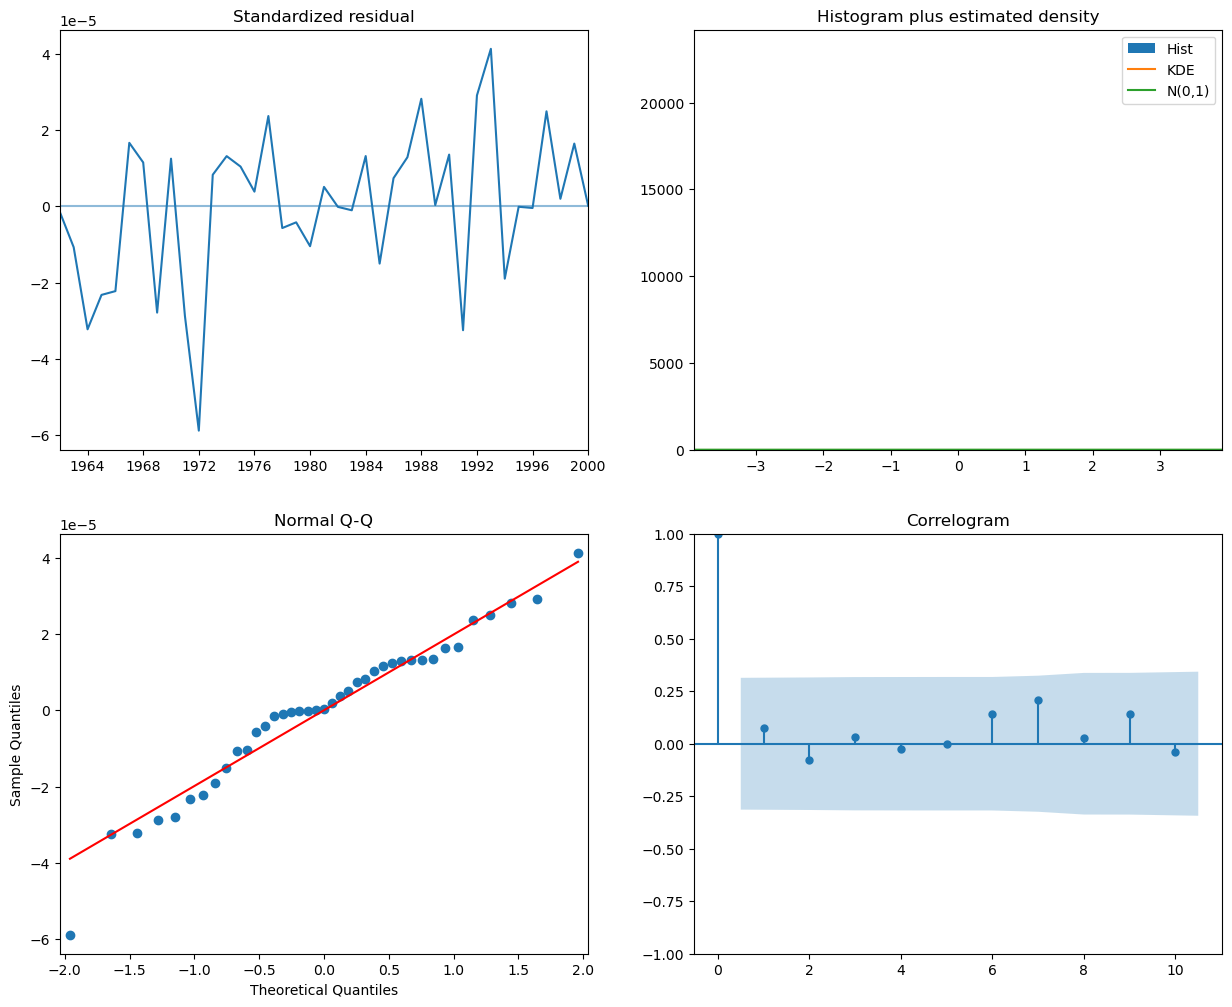

In [126]:
SARIMA_modelp = pm.auto_arima(prec_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


SARIMA_modelp.plot_diagnostics(figsize=(15,12))
plt.show()

The best model found by auto_arima for precipitation is better than the one found for temperature, but I tried to improve it a bit by played with the parameters (on the auto_regressive side)

RMSE: 0.00


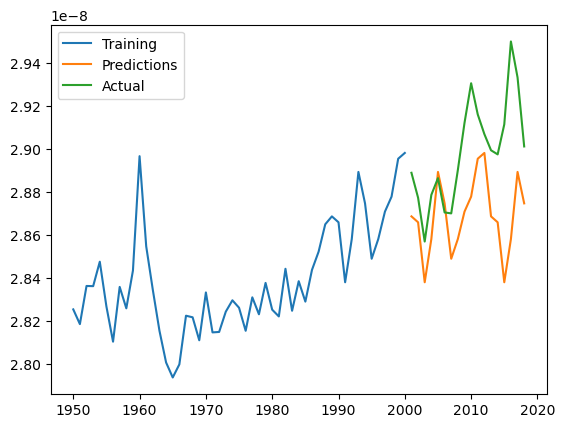

RMSE:  3.823020549110429e-10
R2:  0.12914789492530676
MAPE:  1.056691480099635
AIC:  -50.2901391336272


In [270]:
# Fit SARIMA model
model = SARIMAX(prec_train, order=(25,0,0), seasonal_order=(0,1,0,12))
results = model.fit()

# Make predictions
predictions = results.predict(start=len(prec_train), end=len(prec_train)+17, dynamic=False)

# Evaluate model performance
mse = mean_squared_error(prec_test, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

# Visualize predictions and actual values
plt.plot(prec_train, label='Training')
plt.plot(prec_test.index, predictions, label='Predictions')
plt.plot(prec_test, label='Actual')
plt.legend()
plt.show()


rmse = mean_squared_error(prec_test, predictions, squared=False)
r2 = np.square(np.corrcoef(predictions, prec_test)[0, 1])
mape = np.mean(np.abs((prec_test - predictions) / prec_test)) * 100

print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)
print("AIC: ", model_fit.aic)

# 3. Multivariate Time Series Analysis

## 3.1 VAR

In [151]:
#This model requires us to convert the data into stationary format manualy

temp_train_s = temp_train.diff().dropna()
temp_test_s = temp_test.diff().dropna()

prec_train_s = prec_train.diff().dropna()
prec_test_s = prec_test.diff().dropna()

var_train = pd.merge(temp_train_s, prec_train_s, left_index=True, right_index=True, how='outer')
var_test = pd.merge(temp_test_s, prec_test_s, left_index=True, right_index=True, how='outer')

In [145]:
def adf_test(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] < 0.05:
        print('The data is stationary.')
    else:
        print('The data is not stationary.')
    

adf_test(temp_train_s)

ADF Statistic: -5.0165130716286495
p-value: 2.0582316630005862e-05
Critical Values: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}
The data is stationary.


In [153]:
model = VAR(var_train)
for i in range(1,15):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -48.829261927774084
BIC :  -48.597610462699315
FPE :  6.220913762377332e-22
HQIC:  -48.741373685046355 

Lag Order = 2
AIC :  -49.100157301022406
BIC :  -48.71032375708326
FPE :  4.750413533289875e-22
HQIC:  -48.952838635342204 

Lag Order = 3
AIC :  -48.94133697571835
BIC :  -48.39022917946429
FPE :  5.58452608638584e-22
HQIC:  -48.7339514097865 

Lag Order = 4
AIC :  -49.28073264088328
BIC :  -48.565177311822325
FPE :  4.0002675825102743e-22
HQIC:  -49.01268132597267 

Lag Order = 5
AIC :  -49.182984773688474
BIC :  -48.29972755646743
FPE :  4.455288540617146e-22
HQIC:  -48.853715351349805 

Lag Order = 6
AIC :  -48.98029733676735
BIC :  -47.92600346217928
FPE :  5.544933644379869e-22
HQIC:  -48.589314342233244 

Lag Order = 7
AIC :  -48.93393448216638
BIC :  -47.705190215403434
FPE :  5.954014674497552e-22
HQIC:  -48.480811571216805 

Lag Order = 8
AIC :  -48.8521471107929
BIC :  -47.44546218170636
FPE :  6.705985958049617e-22
HQIC:  -48.33654144902237 

Lag Ord

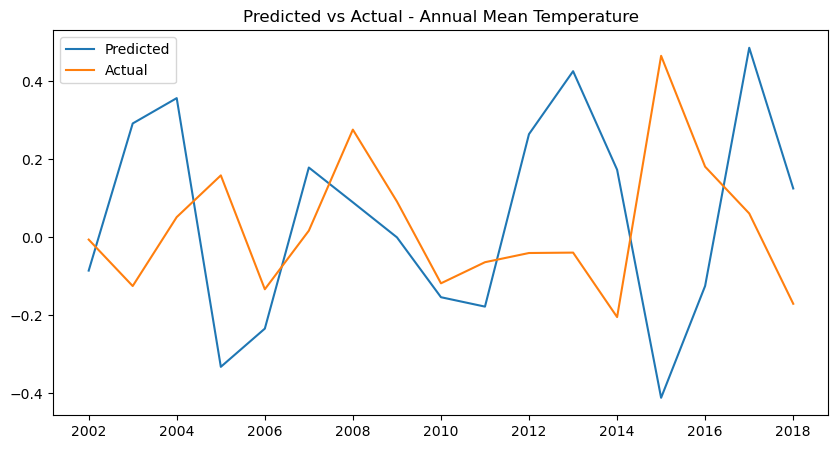

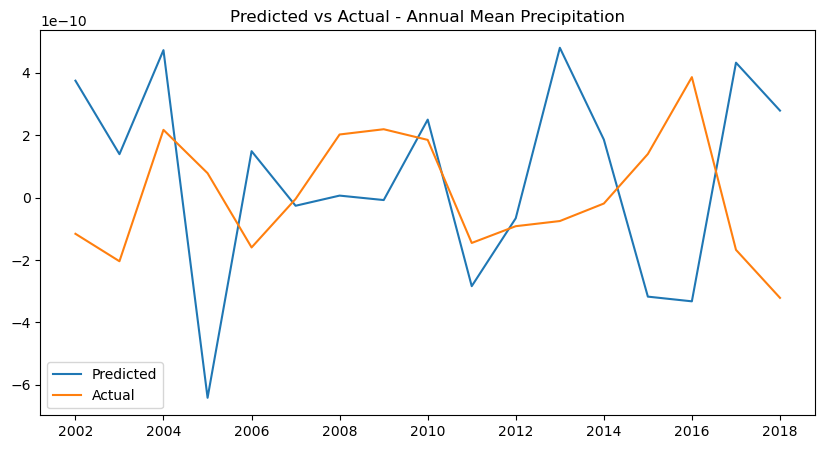

RMSE_temp:  0.35914250443672074
RMSE_prec:  4.16498609437568e-10
R2_temp:  0.13205132139613207
R2_prec:  0.11407406857602108
MAPE_temp:  432.89421049339734
MAPE_prec:  326.47307146247095
AIC:  -50.2901391336272


In [330]:
model = VAR(var_train)
model_fit = model.fit(14)

# Predict the two variables for the test period (2000-2018)
forecast_input = var_test.values
forecast = model_fit.forecast(forecast_input, len(var_test))

# Convert the predicted values to a DataFrame
forecast_df = pd.DataFrame(forecast, index=var_test.index, columns=var_test.columns)

# Visualize predictions and actual values
plt.figure(figsize=(10,5))
plt.plot(forecast_df['temperature'], label='Predicted')
plt.plot(var_test['temperature'], label='Actual')
plt.legend()
plt.title('Predicted vs Actual - Annual Mean Temperature')
plt.show()

# Plot the predicted and actual values for annual_mean_precipitation
plt.figure(figsize=(10,5))
plt.plot(forecast_df['precipitation'], label='Predicted')
plt.plot(var_test['precipitation'], label='Actual')
plt.legend()
plt.title('Predicted vs Actual - Annual Mean Precipitation')
plt.show()


rmse_temp = mean_squared_error(var_test['temperature'], forecast_df['temperature'], squared=False)
rmse_prec = mean_squared_error(var_test['precipitation'], forecast_df['precipitation'], squared=False)
r2_temp = np.square(np.corrcoef(forecast_df['temperature'], var_test['temperature'])[0, 1])
r2_prec = np.square(np.corrcoef(forecast_df['precipitation'], var_test['precipitation'])[0, 1])

mape_temp = np.mean(np.abs((var_test['temperature'] - forecast_df['temperature']) / var_test['temperature'])) * 100
mape_prec = np.mean(np.abs((var_test['precipitation'] - forecast_df['precipitation']) / var_test['precipitation'])) * 100

print("RMSE_temp: ", rmse_temp)
print("RMSE_prec: ", rmse_prec)

print("R2_temp: ", r2_temp)
print("R2_prec: ", r2_prec)

print("MAPE_temp: ", mape_temp)
print("MAPE_prec: ", mape_prec)

print("AIC: ", model_fit.aic)



## 3.2 SARIMAX 

#### 3.2.1 SARIMAX for temperature

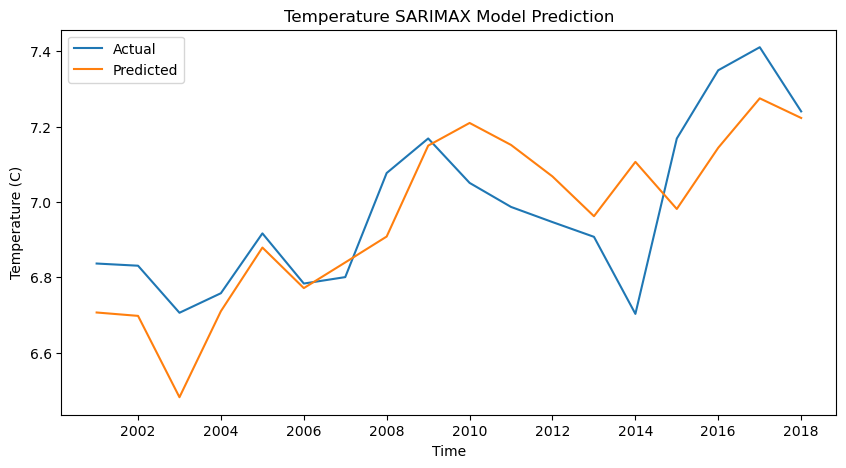

RMSE:  0.15780821294735395
R2:  0.5395002002703816
MAPE:  0.04484432804259988
AIC:  -3.8939768719269736
                                      SARIMAX Results                                      
Dep. Variable:                         temperature   No. Observations:                   51
Model:             SARIMAX(11, 1, 0)x(3, 1, 0, 12)   Log Likelihood                  16.947
Date:                             Thu, 16 Mar 2023   AIC                             -3.894
Time:                                     22:24:57   BIC                             20.670
Sample:                                 01-01-1950   HQIC                             4.846
                                      - 01-01-2000                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

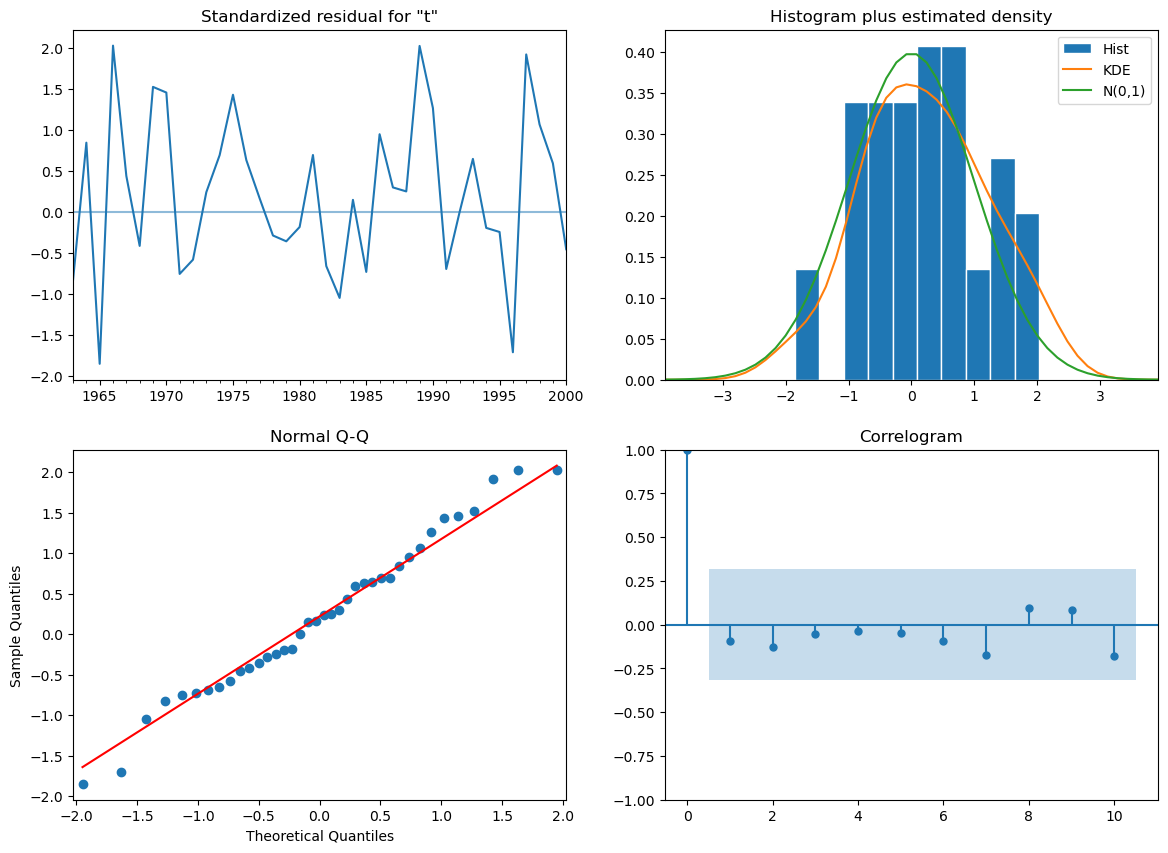

In [328]:
#sarimax with exogenous feature

# SARIMAX Model
model = SARIMAX(temp_train, exogenous=prec_train, order=(11,1,0), seasonal_order=(3,1,0,12))

# Fit the model to the data
results = model.fit()

# Make predictions for the test set
predictions = results.predict(start='2001-01-01', end='2018-01-01', dynamic=False)

# dynamic=> build on the prediction

# Print the predictions
plt.figure(figsize=(10,5))
plt.plot(temp_test-273.15, label='Actual')
plt.plot(predictions-273.15, label='Predicted')
plt.legend(loc='best')
plt.title('Temperature SARIMAX Model Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.show()
   

# Compute the evaluation metrics
rmse = mean_squared_error(temp_test, predictions, squared=False)
r2 = np.square(np.corrcoef(predictions, temp_test)[0, 1])

mape = np.mean(np.abs((temp_test - predictions) / temp_test)) * 100

# Print the evaluation metrics
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)
print("AIC: ", results.aic)

print(results.summary())

results.plot_diagnostics(figsize=(14,10))
plt.show()

### 3.2.2 SARIMAX for precipitation

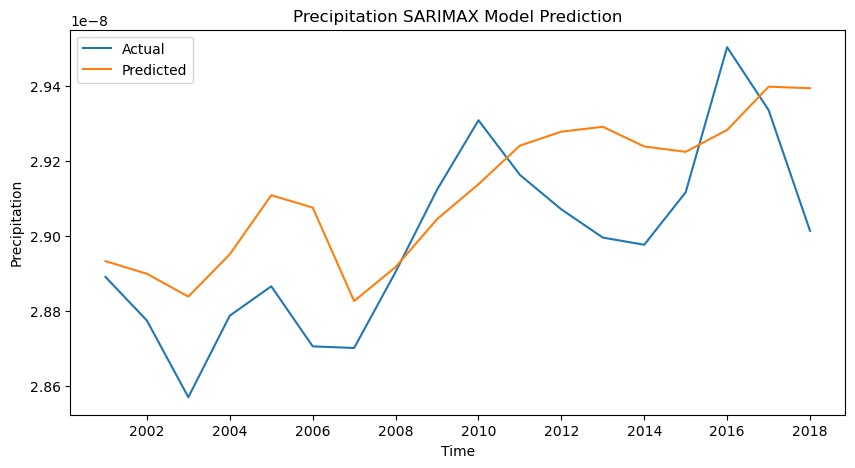

RMSE:  2.074511582023384e-10
R2:  0.5201277341964969
MAPE:  0.6154818411612674
AIC:  -730.7987485607292
                                     SARIMAX Results                                      
Dep. Variable:                      precipitation   No. Observations:                   51
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 373.399
Date:                            Thu, 16 Mar 2023   AIC                           -730.799
Time:                                    22:24:19   BIC                           -717.698
Sample:                                01-01-1950   HQIC                          -726.138
                                     - 01-01-2000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1     

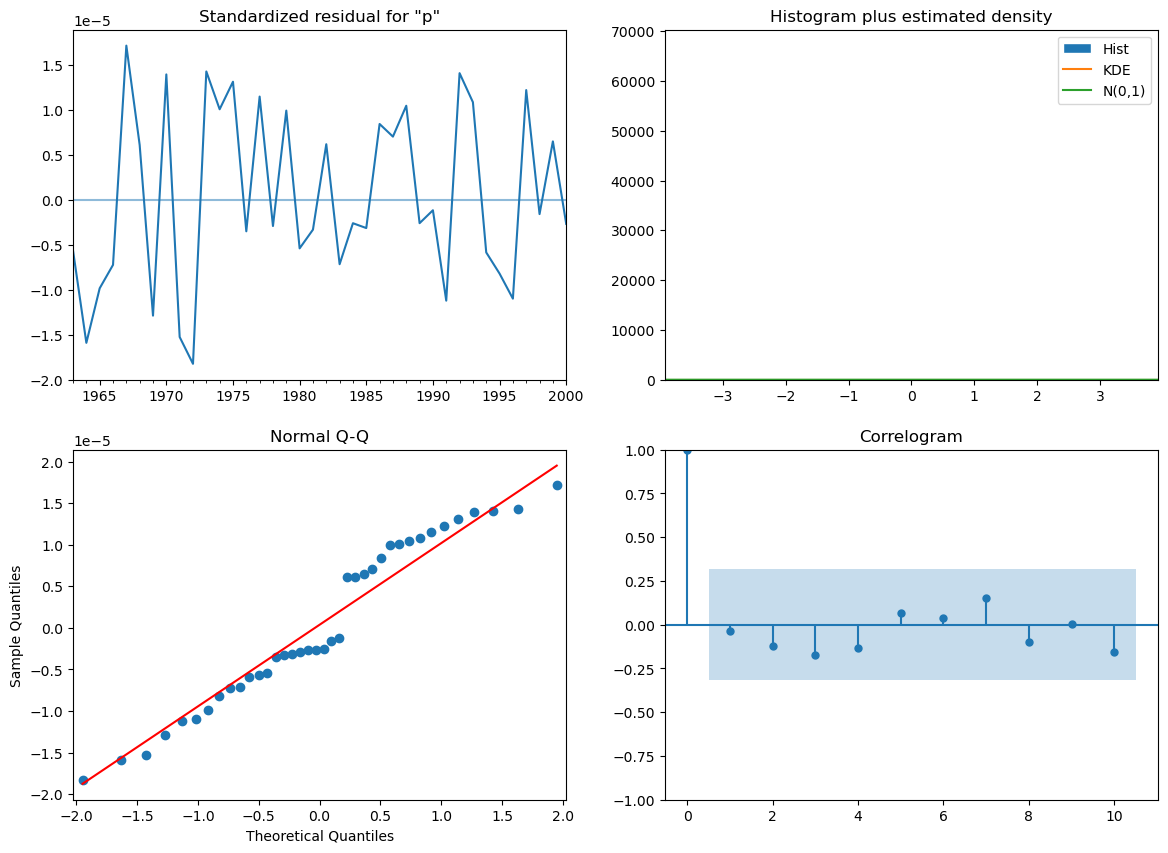

In [327]:
#sarimax with exogenous feature

# SARIMAX Model
model = SARIMAX(prec_train, exogenous=temp_train, order=(5,1,0), seasonal_order=(2,1,0,12))

# Fit the model to the data
results = model.fit()

# Make predictions for the test set
predictions = results.predict(start='2001-01-01', end='2018-01-01', dynamic=False)

# Print the predictions
plt.figure(figsize=(10,5))
plt.plot(prec_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend(loc='best')
plt.title('Precipitation SARIMAX Model Prediction')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.show()
   

# Compute the evaluation metrics
rmse = mean_squared_error(prec_test, predictions, squared=False)
r2 = np.square(np.corrcoef(predictions, prec_test)[0, 1])

mape = np.mean(np.abs((prec_test - predictions) / prec_test)) * 100

# Print the evaluation metrics
print("RMSE: ", rmse)
print("R2: ", r2)
print("MAPE: ", mape)
print("AIC: ", results.aic)


print(results.summary())

results.plot_diagnostics(figsize=(14,10))
plt.show()

correlogram : 95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

The grey area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area. Adding the seasonality component did this! All the points now fall within the 95% confidence interval.

# 4. Demo forecasting 2050 using SARIMAX

In [345]:
temp_train_demo = temp.loc['1950-01-01':'2018-01-01', 'temperature']
temp_test_demo = temp.loc['2019-01-01':'2050-01-01', 'temperature']
tempx_demo= tempx.loc['2019-01-01':'2050-01-01', 'temperature']

prec_train_demo = prec.loc['1950-01-01':'2018-01-01', 'precipitation']
prec_test_demo = prec.loc['2019-01-01':'2050-01-01', 'precipitation']
precx_demo= precx.loc['2019-01-01':'2050-01-01', 'precipitation']


## 4.1 Average world temperature

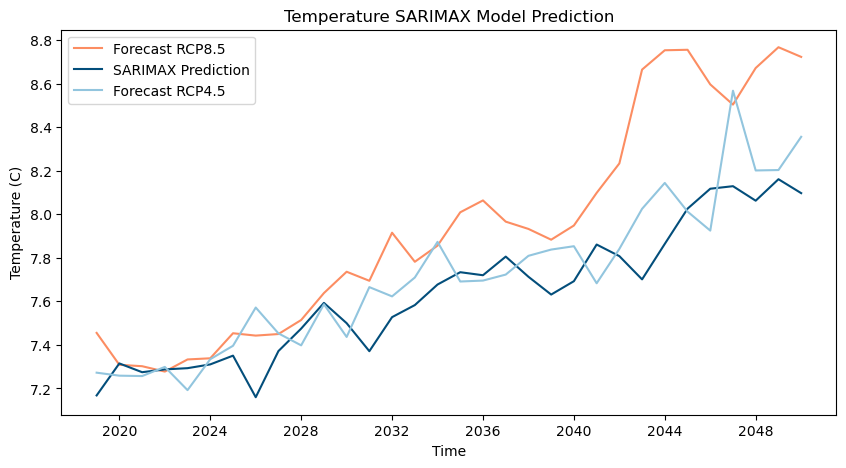

In [351]:

model_demo1 = SARIMAX(temp_train_demo, exogenous=prec_train_demo, order=(11,1,0), seasonal_order=(3,1,0,12))

results_demo1 = model_demo1.fit()

predictions_demo1 = results_demo1.predict(start='2019-01-01', end='2050-01-01', dynamic=False)

# Print the predictions
plt.figure(figsize=(10,5))
plt.plot(temp_test_demo-273.15, label='Forecast RCP8.5', color='#fc8d62')
plt.plot(predictions_demo1-273.15, label='SARIMAX Prediction', color='#034e7b')
plt.plot(tempx_demo-273.15, label='Forecast RCP4.5', color='#92c5de')
plt.legend(loc='best')
plt.title('Temperature SARIMAX Model Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.show()

## 4.2 Average city temperature

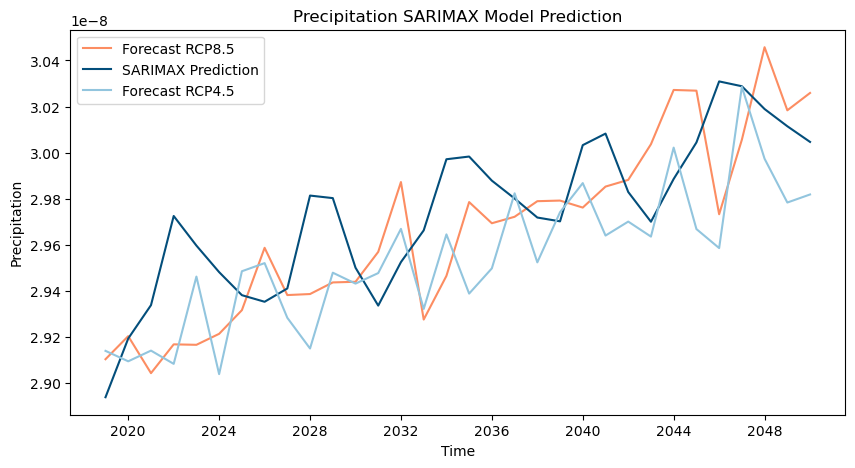

In [350]:
model_demo2 = SARIMAX(prec_train_demo, exogenous=temp_train_demo, order=(5,1,0), seasonal_order=(2,1,0,12))

results_demo2 = model_demo2.fit()

predictions_demo2 = results_demo2.predict(start='2019-01-01', end='2050-01-01', dynamic=False)

# Print the predictions
plt.figure(figsize=(10,5))
plt.plot(prec_test_demo, label='Forecast RCP8.5', color='#fc8d62')
plt.plot(predictions_demo2, label='SARIMAX Prediction', color='#034e7b')
plt.plot(precx_demo, label='Forecast RCP4.5',color='#92c5de')
plt.legend(loc='best')
plt.title('Precipitation SARIMAX Model Prediction')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.show()
